<a href="https://colab.research.google.com/github/PhamTrinhDuc/Text-Classification-using-Transformer-and-Pretrained-BERT/blob/main/Text_Classification_using_Transfomer_Encoder_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Download Data

In [ ]:
!git clone https://github.com/congnghia0609/ntc-scv.git
'''
    Tập dữ liệu tiếng việt về những đánh giá quán ăn của khách
    Hai nhãn 0 và 1 là đánh giá tiêu cực và tích cực
'''

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35
Receiving objects: 100% (39/39), 186.94 MiB | 29.23 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (11/11), done.


'\n    Tập dữ liệu tiếng việt về những đánh giá quán ăn của khách\n    Hai nhãn 0 và 1 là đánh giá tiêu cực và tích cực\n'

In [ ]:
# giải nén file
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

#1. Định dạng lại dữ liệu thành DataFrame

In [ ]:
# data đang ở các dạng file .text, cần định dạng lại data thành các bảng

import os
import pandas as pd
import matplotlib.pyplot as plt

def restructure_data(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [ ]:
path_data = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_DF = restructure_data(path_data['train'])
val_DF = restructure_data(path_data['valid'])
test_DF = restructure_data(path_data['test'])


In [ ]:
# dữ liệu trước khi được xử lí

train_DF.iloc[:5, :]

,sentence,label
0,"Mình thích nhất_là món khô heo ở đây , ăn ngon...",1
1,Mình rất thích đất_nước Hàn_Quốc nên nge nói q...,1
2,"Vi ̣ tri ́ nă ̀ m hơi xa trung_tâm , đô ́ i di...",1
3,"Qua ́ n na ̀ y mi ̀ nh thâ ́ y ngon , thi ́ ch...",1
4,Mình biết và ăn_ở đây khoảng 8 năm . Phát_hiện...,1


In [ ]:
test_DF.iloc[:5, :]

,sentence,label
0,"Món ăn ngon , nhân_viên phục_vụ nhiệt_tình . K...",1
1,"Pizza , mỳ ý siêu ngon , có combo rất rẻ và đư...",1
2,"Quán ở vị_trí rất dễ tìm , gửi xe r đi lên rất...",1
3,Quán này là quán ruột của mình . Ăn từ hồi quá...,1
4,Thật thình cờ vào một buổi tối đẹp trời gặp đư...,1


In [ ]:
pos_train = (train_DF['label'] == 0).count()
neg_train = (train_DF['label'] == 1).count()
pos_train, neg_train

(30000, 30000)

In [ ]:
pos_test = (test_DF['label'] == 0).count()
neg_test = (test_DF['label'] == 1).count()
pos_test, neg_test

(10000, 10000)

#2. Xử lí dữ liệu

In [ ]:
import re
import string


def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [ ]:
train_DF['sentence'] = [preprocess_text(row['sentence']) for idx, row in train_DF.iterrows()]
val_DF['sentence'] = [preprocess_text(row['sentence']) for idx, row in val_DF.iterrows()]
test_DF['sentence'] = [preprocess_text(row['sentence']) for ind, row in test_DF.iterrows()]


In [ ]:
# dữ liệu sau khi được xử lí

train_DF.iloc[:5, :]

,sentence,label
0,mình thích nhất là món khô heo ở đây ăn ngon k...,1
1,mình rất thích đất nước hàn quốc nên nge nói q...,1
2,vi ̣ tri ́ nă ̀ m hơi xa trung tâm đô ́ i diê ...,1
3,qua ́ n na ̀ y mi ̀ nh thâ ́ y ngon thi ́ ch n...,1
4,mình biết và ăn ở đây khoảng năm phát hiện ra ...,1


In [ ]:
test_DF.iloc[:5, :]

,sentence,label
0,món ăn ngon nhân viên phục vụ nhiệt tình không...,1
1,pizza mỳ ý siêu ngon có combo rất rẻ và được n...,1
2,quán ở vị trí rất dễ tìm gửi xe r đi lên rất t...,1
3,quán này là quán ruột của mình ăn từ hồi quán ...,1
4,thật thình cờ vào một buổi tối đẹp trời gặp đư...,1


#3. Chuẩn bị dữ liệu cho model

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [ ]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

# test hàm
sentence = "We are learning AI"
tokenizer_sentence = tokenizer(sentence)
print(tokenizer_sentence)


['we', 'are', 'learning', 'ai']


In [ ]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator
vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_DF['sentence'], tokenizer),
    max_tokens = vocab_size,
    specials = ['<pad>', '<unk>']
)

vocabulary.set_default_index(vocabulary['<unk>'])

# test hàm
vocabulary.get_stoi()

In [ ]:
from torchtext.data.functional import to_map_style_dataset


def prepare_dataset(df):
    for idx, row in df.iterrows():
        sentence = row['sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label
        # print(encoded_sentence, label)
        # break

train_dataset = prepare_dataset(train_DF)
train_dataset = to_map_style_dataset(train_dataset)

val_dataset = prepare_dataset(val_DF)
val_dataset = to_map_style_dataset(val_dataset)

test_dataset = prepare_dataset(test_DF)
test_dataset = to_map_style_dataset(test_dataset)

#4. Tạo DataLoader

In [ ]:
import torch

seq_length = 100

def collate_batch(batch):
    # tạo inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence + ([0] * (seq_length - len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
                    for sentence in sentences
        ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)
    return encoded_sentences, labels

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = collate_batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = collate_batch
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [ ]:
next(iter(train_loader))

(tensor([[8685,  818,  139,  ...,    0,    0,    0],
         [3319, 1015,   19,  ...,    0,    0,    0],
         [ 926,   29,  467,  ...,    0,    0,    0],
         ...,
         [ 675,    2,   82,  ...,    0,    0,    0],
         [   6,   60,    7,  ...,    0,    0,    0],
         [ 127, 1716,   58,  ...,  216, 7061,   63]]),
 tensor([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
         1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
         0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
         0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 1, 1, 0, 0, 0]))

In [ ]:
len(train_loader)

235

In [ ]:
sentence, label = next(iter(train_loader))
sentence.shape

torch.Size([128, 100])

#5. Trainer

In [ ]:
import time

def train_epoch(model, optimizer, criterion, train_loader, device, epoch=0, log_interval=50):
    model.train()
    train_acc , train_loss = 0.0 , 0.0
    total = 0.0
    start_time = time.time()


    for idx, (sentence, label) in enumerate(train_loader):
        sentence = sentence.to(device)
        labels = label.to(device)
        optimizer.zero_grad()

        outputs = model(sentence) # tính outputs của model
        loss = criterion(outputs, labels) # tính loss
        train_loss += loss.item()

        #backward
        loss.backward()
        optimizer.step()

        train_acc += (torch.argmax(outputs, 1) == labels).sum().item()
        total += len(labels)

        if idx % log_interval == 0 and idx > 0:
            eslaped = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.2f}".format(
                    epoch, idx, len(train_loader), train_acc / total
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = train_acc / total
    epoch_loss = train_loss / len(train_loader)
    return epoch_acc, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, val_loader, device):
    model.eval()
    test_acc, test_loss = 0.0, 0.0
    total = 0.0

    with torch.no_grad():
        for idx, (sentence, label) in enumerate(val_loader):
            sentence = sentence.to(device)
            label = label.to(device)

            outputs = model(sentence)
            loss = criterion(outputs, label)

            test_acc += (torch.argmax(outputs, 1) == label).sum().item()
            test_loss += loss.item()
            total += len(label)

    epoch_acc = test_acc / total
    epoch_loss = test_loss / len(test_loader)
    return epoch_acc, epoch_loss

In [ ]:
def traning(model, optimizer, criterion, train_loader, val_loader, num_epochs,
             model_name, save_model, device):

    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs):
        epoch_start_time = time.time()

        #train
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_loader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # eval
        eval_acc, eval_loss = evaluate_epoch(model, criterion, val_loader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # save model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f"/{model_name}.pt")

        times.append(time.time() - epoch_start_time)
        print("-" * 60)
        print(
            "| end of epoch {:3d} | Time {:5.2f}s | Train Acc {:8.3f} | Train Loss {:8.3f} "
            "| Val Acc {:8.3f} | Val Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 60)

    model.load_state_dict(torch.load(save_model + f"/{model_name}.pt"))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

#6. Modeling

####**Token and Positional Embedding**


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, embed_dim, vocab_size, max_length, device):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        return output1 + output2

####**Transformer-Encoder Block**

In [ ]:
class TransfomerBlock(nn.Module):

    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim = embed_dim,
            num_heads = num_heads,
            batch_first=True
        )

        self.ffn = nn.Sequential(
            nn.Linear(in_features = embed_dim, out_features = ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = ff_dim, out_features = embed_dim, bias=True)
        )

        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)


    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

In [ ]:

class TransfomerEncoder(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, ff_dim,
                 num_layers, num_heads, device, dropout=0.1):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(embed_dim, vocab_size, max_length, device)

        # num_layer: số lớp của transfomer encoder
        # num_heads: số khối MultiheadAttention
        self.encoder = nn.ModuleList(
            [
                TransfomerBlock(embed_dim, num_heads, ff_dim, dropout)
                for i in range(num_layers)
            ]
        )

    def forward(self, x):
        out = self.embedding(x)
        for layer in self.encoder:
            out = layer(out, out, out)
        return out

In [ ]:
batch_size = 32
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout=0.1

x = torch.randint(1, 2, (32, 100))

encoder = TransfomerEncoder(vocab_size, max_length, embed_dim,
                              ff_dim, num_layers, num_heads, 'cpu')

output = encoder(x)
output.shape

torch.Size([32, 100, 200])

####**Model Transfomer**

In [ ]:
class TransfomerEncoderCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, ff_dim,  num_layers, num_heads,
                 device, drop_out=0.1):
        super().__init__()
        self.encoder = TransfomerEncoder(vocab_size, max_length, embed_dim, ff_dim,
                                         num_layers, num_heads, device, drop_out)

        self.pooling = nn.AvgPool1d(kernel_size=max_length) #
        self.fc1 = nn.Linear(in_features=embed_dim, out_features= 32)
        self.fc2 = nn.Linear(in_features=32, out_features=2)
        self.dropout = nn.Dropout(p=drop_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.encoder(x)
        out = self.pooling(out.permute(0, 2, 1)).squeeze() # loại bỏ chiều có kích thước bằng 1
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
x = torch.randint(1, 2, (32, 100))

encoder = TransfomerEncoderCls(vocab_size, max_length, embed_dim,
                              ff_dim, num_layers, num_heads, 'cpu',  dropout)

output = encoder(x)
output.shape

torch.Size([32, 2])

#7. Training

In [ ]:
# test cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
x

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransfomerEncoderCls(vocab_size, max_length, embed_dim, ff_dim,
                             num_layers, num_heads, device, dropout)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
criterion = nn.CrossEntropyLoss()
num_epochs = 100
save_model = '/content/drive/MyDrive'
model_name = 'transfomer'

model, metrics = traning(model, optimizer, criterion, train_loader, val_loader, num_epochs,
             model_name, save_model, device)

| epoch   1 |    50/  235 batches | accuracy     0.51
| epoch   1 |   100/  235 batches | accuracy     0.52
| epoch   1 |   150/  235 batches | accuracy     0.53
| epoch   1 |   200/  235 batches | accuracy     0.53
------------------------------------------------------------
| end of epoch   1 | Time  9.82s | Train Acc    0.534 | Train Loss    0.690 | Val Acc    0.608 | Val Loss    0.684 
------------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy     0.59
| epoch   2 |   100/  235 batches | accuracy     0.60
| epoch   2 |   150/  235 batches | accuracy     0.60
| epoch   2 |   200/  235 batches | accuracy     0.61
------------------------------------------------------------
| end of epoch   2 | Time  7.67s | Train Acc    0.619 | Train Loss    0.677 | Val Acc    0.684 | Val Loss    0.663 
------------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy     0.68
| epoch   3 |   100/  235 batches | ac

#8. Evaluate

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, val_accs, train_losses, val_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axs[0].plot(epochs, train_accs, label = 'Training')
    axs[0].plot(epochs, val_accs, label = 'EValuation')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Acccuracy")

    axs[1].plot(epochs, train_losses, label = 'Training')
    axs[1].plot(epochs, val_losses, label = 'Evaluation')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    plt.legend()

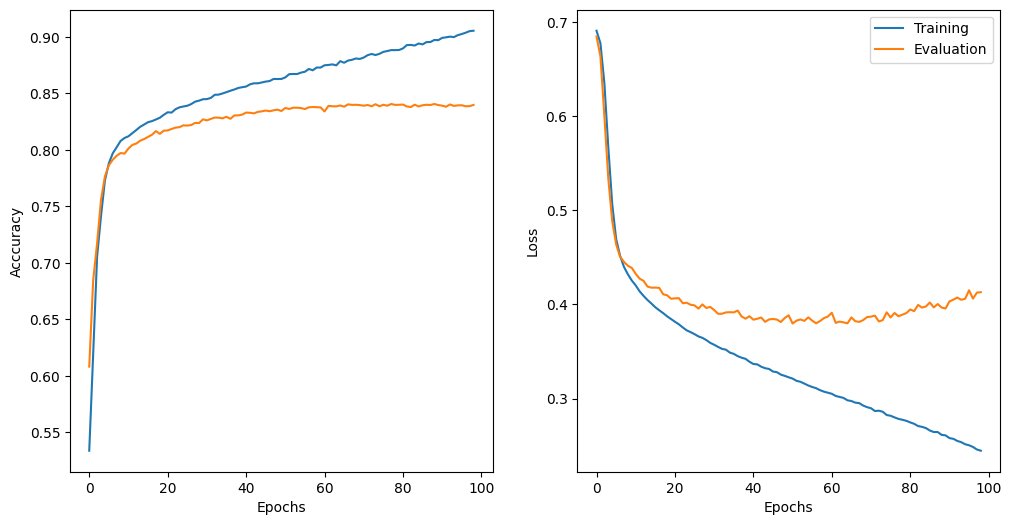

In [ ]:
plot_result(
    num_epochs-1, # (99, 99)
    metrics['train_accuracy'],
    metrics['valid_accuracy'],
    metrics['train_loss'],
    metrics['valid_loss']
)

In [ ]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_loader, device)
test_acc, test_loss

(0.8441, 0.3905507612831985)